In [1]:
import os
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis, norm
import re

In [2]:
# Define sensor data type (already provided)
sensor_dtype = np.dtype([
    ("x", ">f4"),
    ("y", ">f4"),
    ("z", ">f4"),
    ("time", ">i8"),
])

# Step 2: Utility Functions
# These include the data loading and synchronization functions you provided

def load_raw_sensor_data(path):
    acc_files = sorted([f for f in os.listdir(path) if f.endswith('.bin') and 'accelerometer' in f])
    gyro_files = sorted([f for f in os.listdir(path) if f.endswith('.bin') and 'gyroscope' in f])

    all_acc_data = []
    all_gyro_data = []

    # Load accelerometer data
    for file in acc_files:
        boot_time_nanos = int(file.split("_")[0]) * 1e6
        file_path = os.path.join(path, file)
        acc_data = np.fromfile(file_path, dtype=sensor_dtype)
        first_event_time = acc_data['time'][0]
        corrected_timestamps = ((acc_data['time'] - first_event_time) + boot_time_nanos) / 1e9
        corrected_datetimes = pd.to_datetime(corrected_timestamps, unit='s')
        df = pd.DataFrame(acc_data[["x", "y", "z"]].byteswap().newbyteorder())
        df['time'] = corrected_datetimes
        all_acc_data.append(df)

    # Load gyroscope data
    for file in gyro_files:
        boot_time_nanos = int(file.split("_")[0]) * 1e6
        file_path = os.path.join(path, file)
        gyro_data = np.fromfile(file_path, dtype=sensor_dtype)
        first_event_time = gyro_data['time'][0]
        corrected_timestamps = ((gyro_data['time'] - first_event_time) + boot_time_nanos) / 1e9
        corrected_datetimes = pd.to_datetime(corrected_timestamps, unit='s')
        df = pd.DataFrame(gyro_data[["x", "y", "z"]].byteswap().newbyteorder())
        df['time'] = corrected_datetimes
        all_gyro_data.append(df)

    return pd.concat(all_acc_data), pd.concat(all_gyro_data)

def sync_sensors(acc_data, gyro_data):
    common_start_time = max(acc_data['time'].min(), gyro_data['time'].min())
    common_end_time = min(acc_data['time'].max(), gyro_data['time'].max())

    acc_synced = acc_data[(acc_data['time'] >= common_start_time) & (acc_data['time'] <= common_end_time)]
    gyro_synced = gyro_data[(gyro_data['time'] >= common_start_time) & (gyro_data['time'] <= common_end_time)]

    return acc_synced.reset_index(drop=True), gyro_synced.reset_index(drop=True)

In [5]:
class DataAnalyzer:
    def __init__(self, data_path):
        self.data_path = data_path
        self.session_metrics = {}
        self.durations = []
        self.acc_characteristics = None
        self.gyro_characteristics = None
        self.subject_sessions = {}

    def analyze_sessions(self):
        """Analyze sessions to calculate core metrics."""
        subject_pattern = re.compile(r'^(\d+)')
        
        self.session_metrics = {
            "total_sessions": 0,
            "unique_subjects": 0,
            "total_recording_duration": 0.0,
            "average_session_duration": 0.0,
            "std_session_duration": 0.0,
            "median_session_duration": 0.0,
            "average_sampling_rate": 0.0,
            "std_sampling_rate": 0.0,
            "total_samples": 0
        }
        
        sampling_rates = []
        sample_counts = []
        
        processed_ids = ['1_meal_2', '4', '5', '6', '9', '14', '17_meal_2', '18', '19', '20']
        
        for folder in os.listdir(self.data_path):
            folder_path = os.path.join(self.data_path, folder)
            if os.path.isdir(folder_path):
                    match = subject_pattern.match(folder)
                    if not match:
                        continue
                    subject_id = match.group(1)
        
                    # Check if the folder name (or the extracted ID) is in the processed list
                    if folder not in processed_ids:
                        continue
                        
                    if subject_id not in self.subject_sessions:
                        self.subject_sessions[subject_id] = 0
                    self.subject_sessions[subject_id] += 1

                    acc_data, gyro_data = load_raw_sensor_data(folder_path)
                    acc_synced, gyro_synced = sync_sensors(acc_data, gyro_data)

                    session_duration = (acc_synced['time'].iloc[-1] - acc_synced['time'].iloc[0]).total_seconds()
                    self.durations.append(session_duration)

                    num_samples = len(acc_synced)
                    sample_counts.append(num_samples)

                    sampling_rate = num_samples / session_duration
                    sampling_rates.append(sampling_rate)

                    self.session_metrics["total_sessions"] += 1
                    self.session_metrics["total_recording_duration"] += session_duration
                    self.session_metrics["total_samples"] += num_samples

        self.session_metrics["unique_subjects"] = len(self.subject_sessions)
        self.session_metrics["average_session_duration"] = np.mean(self.durations)
        self.session_metrics["std_session_duration"] = np.std(self.durations)
        self.session_metrics["median_session_duration"] = np.median(self.durations)
        self.session_metrics["average_sampling_rate"] = np.mean(sampling_rates)
        self.session_metrics["std_sampling_rate"] = np.std(sampling_rates)

    # def plot_session_duration_distribution(self): # old more bins - empty
    #     """Plot distribution of session durations (in minutes) with mean duration marked."""
    #     # Convert durations to minutes
    #     metadata = {
    #         '/Title': 'Session Duration Distribution',
    #         '/Author': 'Ioannis Levi',
    #         '/Subject': 'Statistical analysis of session durations in Bite Weight Estimation Thesis.',
    #         '/Keywords': 'Session Duration, Analysis, Reproducibility',
    #         '/CreationDate': 'D:20241116',
    #         '/ModificationDate': 'D:20241116',
    #         '/Version': 'v1.0',
    #         '/Producer': 'Matplotlib 3.8.2, Python 3.11',
    #         '/Comments': 'To update this plot, rerun notebook dataset_statistics_final.ipynb.',
    #         '/SourceData': 'SDP -> data_sessions.csv',
    #         '/License': 'CC BY 4.0',
    #         '/Copyright': '© 2024 Ioannis Levi',
    #     }
    # 
    # 
    #     durations_in_minutes = [duration / 60 for duration in self.durations]
    # 
    #     plt.figure(figsize=(10, 6))
    #     sns.histplot(durations_in_minutes, kde=True, bins=20, stat="density")  # Density plot for distribution
    #     plt.axvline(np.mean(durations_in_minutes), color='red', linestyle='--', label=f'Μέση Διάρκεια = {np.mean(durations_in_minutes):.2f}λ.')
    #     plt.xlabel("Διάρκεια Συνεδρίας (λεπτά)")
    #     plt.ylabel("Πυκνότητα")
    #     plt.title("Κατανομή Διάρκειας Συνεδριών", fontweight='bold', fontsize=16)
    #     plt.legend()
    #     plt.savefig("data_specs/session_duration_distribution_minutes_greek.pdf",format='pdf', dpi=600, metadata=metadata)
    #     plt.show()
    
    def plot_session_duration_distribution(self):
        durations_in_minutes = [duration / 60 for duration in self.durations]
    
        plt.figure(figsize=(10, 6))
        sns.histplot(durations_in_minutes, kde=True, bins=10, stat="density")  # Reduced bins for less empty spaces
        plt.axvline(np.mean(durations_in_minutes), color='red', linestyle='--', label=f'Μέση Διάρκεια = {np.mean(durations_in_minutes):.2f}λ.')
        plt.xlabel("Διάρκεια Συνεδρίας (λεπτά)")
        plt.ylabel("Πυκνότητα")
        plt.title("Κατανομή Διάρκειας Συνεδριών", fontweight='bold', fontsize=16)
        plt.legend()
        plt.savefig("data_specs/10_bin_session_duration_distribution_minutes_greek.pdf", format='pdf', dpi=600)
        plt.show()

        

    def plot_inter_sample_interval_distribution(self, acc_data, session_name="session"):
        """Plot distribution of inter-sample intervals for each session."""
        inter_sample_intervals = acc_data['time'].diff().dt.total_seconds().dropna()
        
        plt.figure(figsize=(10, 6))
        sns.histplot(inter_sample_intervals, kde=True, bins=30)
        plt.xlabel("Διάστημα μεταξύ δειγμάτων (s)")  # Inter-Sample Interval in Greek
        plt.ylabel("Συχνότητα")  # Frequency
        plt.title(f"Κατανομή διαστήματος μεταξύ δειγμάτων ({session_name})")
        plt.axvline(inter_sample_intervals.mean(), color='red', linestyle='--', label='Μέση Τιμή')
        plt.legend()
        plt.savefig(f"data_specs/inter_sample_interval_distribution_{session_name}.png", dpi=300, bbox_inches='tight')
        plt.show()

    
    def calculate_data_quality_metrics(self, acc_data, session_name="session"):
        """Calculate timestamp continuity and sample interval consistency for each session."""
        inter_sample_intervals = acc_data['time'].diff().dt.total_seconds().dropna()

        # Expected interval and tolerance
        expected_interval = inter_sample_intervals.median()
        tolerance = 0.01 * expected_interval  # 1% tolerance of expected interval

        # Timestamp continuity (percentage of intervals within tolerance)
        continuous_intervals = inter_sample_intervals[abs(inter_sample_intervals - expected_interval) <= tolerance]
        timestamp_continuity = (len(continuous_intervals) / len(inter_sample_intervals)) * 100

        # Sample interval consistency
        sample_interval_summary = {
            "median_interval": expected_interval,
            "5th_percentile": np.percentile(inter_sample_intervals, 5),
            "95th_percentile": np.percentile(inter_sample_intervals, 95)
        }

        # Add results to session metrics
        self.session_metrics[session_name] = {
            "timestamp_continuity_percentage": timestamp_continuity,
            "sample_interval_consistency": sample_interval_summary
        }

    def calculate_signal_characteristics(self, data, sensor_type):
        """Calculate signal characteristics with an interval range [min, max] for each axis."""
        characteristics = {}
        for axis in ['x', 'y', 'z']:
            axis_data = data[axis]
            min_val = axis_data.min()
            max_val = axis_data.max()
            mean_val = axis_data.mean()
            std_val = axis_data.std()
            skew_val = skew(axis_data)
            kurt_val = kurtosis(axis_data)
            snr_db = 10 * np.log10(np.mean(axis_data**2) / np.var(axis_data))
    
            characteristics[axis] = {
                "range": [min_val, max_val],  # Interval [min, max] for each axis
                "mean": mean_val,
                "std": std_val,
                "skew": skew_val,
                "kurtosis": kurt_val,
                "snr_db": snr_db
            }
        
        characteristics_df = pd.DataFrame(characteristics).T
        characteristics_df.index.name = f"{sensor_type.capitalize()} Axis"
        return characteristics_df


    def analyze_signal_characteristics(self, acc_data, gyro_data):
        """Perform signal analysis and save results as tables."""
        self.acc_characteristics = self.calculate_signal_characteristics(acc_data, "accelerometer")
        self.gyro_characteristics = self.calculate_signal_characteristics(gyro_data, "gyroscope")

    def save_metrics_to_json(self, output_dir="data_specs"):
        """Save all metrics and characteristics in a single JSON file within a specific directory."""
        os.makedirs(output_dir, exist_ok=True)
        
        # Convert all elements in session_metrics, acc_characteristics, and gyro_characteristics to standard Python types
        def convert_to_serializable(obj):
            if isinstance(obj, np.generic):  # Convert NumPy types to native Python types
                return obj.item()
            elif isinstance(obj, dict):  # Recursively apply for dictionaries
                return {k: convert_to_serializable(v) for k, v in obj.items()}
            elif isinstance(obj, list):  # Apply for lists
                return [convert_to_serializable(i) for i in obj]
            return obj  # Return as is if no conversion is necessary
    
        # Prepare results dictionary with converted data
        results = {
            "session_metrics": convert_to_serializable(self.session_metrics),
            "accelerometer_characteristics": convert_to_serializable(self.acc_characteristics.to_dict()),
            "gyroscope_characteristics": convert_to_serializable(self.gyro_characteristics.to_dict())
        }
    
        # Define output file path
        output_path = os.path.join(output_dir, "session_analysis.json")
    
        # Save results to JSON file
        with open(output_path, "w") as f:
            json.dump(results, f, indent=4)
    
        print(f"Metrics and characteristics saved to {output_path}")

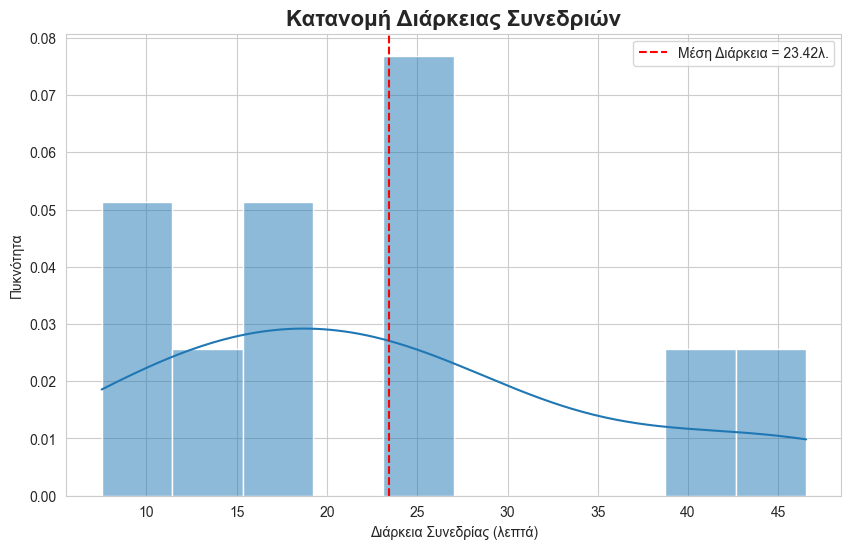

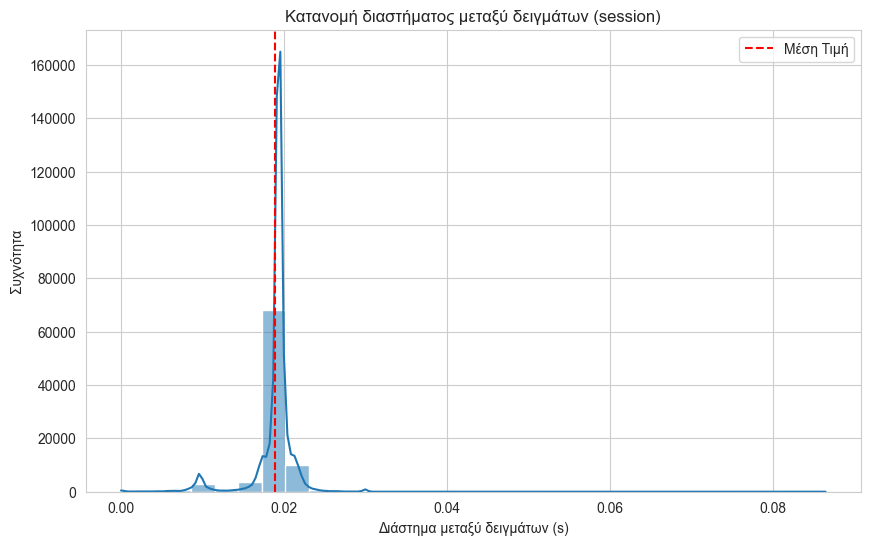

Metrics and characteristics saved to data_specs/session_analysis.json


In [6]:
# Usage Example
data_path = "../data/raw"  # Update to your data directory path
analyzer = DataAnalyzer(data_path)

# Step 1: Analyze sessions
analyzer.analyze_sessions()

# Step 2: Plot session duration distribution
analyzer.plot_session_duration_distribution()

# Step 3: Signal Characteristics Analysis
# Example: Analyze signal characteristics for one subject (can be expanded to loop through all subjects)
acc_data, gyro_data = load_raw_sensor_data(os.path.join(data_path, "1_meal_1"))  # Example subject folder
analyzer.analyze_signal_characteristics(acc_data, gyro_data)

# Step 4: Plot Inter-Sample Interval Distribution
analyzer.plot_inter_sample_interval_distribution(acc_data)

# Step 5: Data Quality Metrics
analyzer.calculate_data_quality_metrics(acc_data)

# Step 6: Save results to JSON
analyzer.save_metrics_to_json()

/var/folders/nb/pd4xdd3d6tl59dcyd629fj080000gn/T/ipykernel_91124/3975884041.py:34: UserWarning: Unknown infodict keyword: '/Title'. Must be one of {'Subject', 'ModDate', 'Creator', 'Author', 'Producer', 'Keywords', 'CreationDate', 'Title', 'Trapped'}.
  plt.savefig("age_distribution_greek.pdf", format='pdf', dpi=600, metadata=metadata)
/var/folders/nb/pd4xdd3d6tl59dcyd629fj080000gn/T/ipykernel_91124/3975884041.py:34: UserWarning: Unknown infodict keyword: '/Author'. Must be one of {'Subject', 'ModDate', 'Creator', 'Author', 'Producer', 'Keywords', 'CreationDate', 'Title', 'Trapped'}.
  plt.savefig("age_distribution_greek.pdf", format='pdf', dpi=600, metadata=metadata)
/var/folders/nb/pd4xdd3d6tl59dcyd629fj080000gn/T/ipykernel_91124/3975884041.py:34: UserWarning: Unknown infodict keyword: '/Subject'. Must be one of {'Subject', 'ModDate', 'Creator', 'Author', 'Producer', 'Keywords', 'CreationDate', 'Title', 'Trapped'}.
  plt.savefig("age_distribution_greek.pdf", format='pdf', dpi=600, me

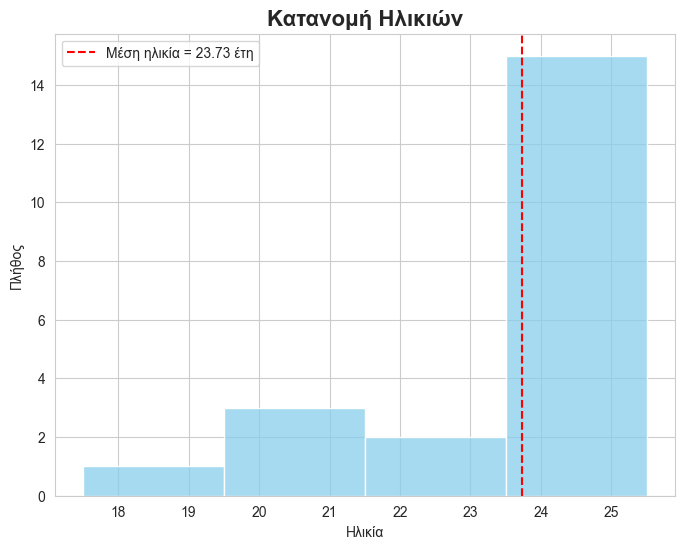

In [5]:
def plot_age_distribution(data):
    """Plot distribution of age with frequency and save as PDF with metadata."""
    
    # Metadata for the PDF
    metadata = {
        '/Title': 'Age Distribution',
        '/Author': 'Ioannis Levi',
        '/Subject': 'Statistical analysis of age distribution in Bite Weight Estimation Thesis.',
        '/Keywords': 'Age Distribution, Analysis, Reproducibility',
        '/CreationDate': 'D:20241116',
        '/ModificationDate': 'D:20241116',
        '/Version': 'v1.0',
        '/Producer': 'Matplotlib 3.8.2, Python 3.11',
        '/Comments': 'To update this plot, rerun notebook dataset_statistics_final.ipynb.',
        '/SourceData': 'Age Data',
        '/License': 'CC BY 4.0',
        '/Copyright': '© 2024 Ioannis Levi',
    }
    
    # Extract age and frequency
    ages = [18, 21, 22, 24, 25, 26]
    frequencies = [1, 3, 2, 4, 11, 1]

    # Expand data based on frequency
    age_data = np.repeat(ages, frequencies)
    
    plt.figure(figsize=(8, 6))
    sns.histplot(age_data, bins=np.arange(17.5, 27.5, 2), kde=False, color='skyblue', stat='count')
    plt.axvline(np.mean(age_data), color='red', linestyle='--', label=f'Μέση ηλικία = {np.mean(age_data):.2f} έτη')
    plt.xlabel("Ηλικία")
    plt.ylabel("Πλήθος")
    plt.title("Κατανομή Ηλικιών", fontweight='bold', fontsize=16)
    plt.legend()
    plt.savefig("age_distribution_greek.pdf", format='pdf', dpi=600, metadata=metadata)
    plt.show()

# Example usage
plot_age_distribution(None)